In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/colab/privgwas/fuzzy-gwas/
!pip3 install pickle5

/content/drive/MyDrive/colab/privgwas/fuzzy-gwas
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from factorization_mechanism import *
import pdb
from matplotlib import pyplot
import pickle5 as pickle


Read in the data. 


In [28]:

with open('Data/query_submatrix.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    query_matrix = pickle.load(f)

m, n = query_matrix.shape
m, n

(1000, 100)

Create pytorch dataset class.

In [29]:
class SNPDataset(Dataset):
    def __init__(self, query_matrix):
        self.query_matrix = torch.tensor(query_matrix)
    def __len__(self):
        return query_matrix.shape[0]
    def __getitem__(self, idx):
        return query_matrix[idx, :], idx



Create custom pytorch factorization module. 

Goal: Factor query_matrix = $LR^T $ such that $LR^T \approx Q$ and
$||R||_1$ and $||L||_1$ are low (low row norm for L, R)

First attempt: two separate variables L, R, optimize using alternating gradient descent, where we optimize the function
$$||LR^{T}-Q||_1 + \lambda*||R||_1*||L||$$




In [30]:
class Factorization(torch.nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, m, n, k, eps, delta):
        super(Factorization, self).__init__()
        # initialize weights with random numbers
        weights_L = torch.distributions.Uniform(0, 0.1).sample((m, k))
        weights_R = torch.distributions.Uniform(0, 0.1).sample((n, k))
        # make weights torch parameters
        self.weights_L = torch.nn.Parameter(weights_L)
        self.weights_R = torch.nn.Parameter(weights_R)
        self.eps = eps
        self.delta = delta

    def forward(self, ids):
        q_hat = torch.matmul(self.weights_L, torch.transpose(self.weights_R, 0, 1))
        return q_hat[ids,:], self.weights_L, self.weights_R

    def pca_initialization(self, query_matrix, k_components):
        svd = np.linalg.svd(query_matrix, full_matrices=False, compute_uv=True)
        U = svd[0]
        s = svd[1]
        Vh = svd[2]
        U_k = U[:, range(k_components)]
        S_k = np.diag(s[range(k_components)])
        V_kh = torch.tensor(Vh[range(k_components), :])
        self.weights_L = torch.nn.Parameter(torch.tensor(np.matmul(U_k, S_k)))
        self.weights_R = torch.nn.Parameter(torch.transpose(V_kh, 0, 1))


# If M = LR^T-X, and if our loss fn is the MSE then the loss can be upper bounded by
# 1/m * (||M||_F^2*1/n + 1/n^2||L||_F^2||R||_{1->2}^2*privacy_blah
# Frobenius norms can be replaced with the spectral norm, set p = '2'
def loss_fn_l_2(outputs, q_ids, epsilon=1.0, delta = 1e-6, silent=False, p='fro'):

    q_hat, L, R = outputs
    m = L.shape[0]
    n_samp = q_ids.shape[0]
    approximation_loss = 1/m*(1/n_samp*torch.pow(torch.linalg.matrix_norm(q_hat - q_ids, ord=p), 2))
    sigma = gaussian_mech_noise(torch.max(torch.norm(R, dim=1)), epsilon, delta, tensor=True)
    noise_loss = (1/np.power(n, 2)) * torch.pow(torch.linalg.matrix_norm(L, ord=p), 2)*torch.pow(sigma, 2)
 
    if not silent:
        print('mse: {}, mse of appx: {}, per coord noise: {}'.format(np.round(approximation_loss.detach(),4) +
                                                                                     np.round(noise_loss.detach(),4),
                                                                                     np.round(approximation_loss.detach(),4),
                                                                                     np.round(noise_loss.detach(), 4)))
    return approximation_loss + noise_loss


def training_loop(dataloader, model, loss, optimizer, device):
    "Training loop for torch model."
    for batch, (q, ids) in enumerate(dataloader):

        # send data to device 
        q, ids = q.to(device), ids.to(device)
        # zero gradients before minibatch
        optimizer.zero_grad()

        outputs = model(ids)
        # Compute prediction and loss
        loss = loss_fn_l_2(outputs, q, epsilon=model.eps, delta=model.delta, silent=False)
        # Backpropagation
        loss.backward()
        optimizer.step()
    loss_fn_l_2(outputs, q, epsilon=model.eps, delta=model.delta, silent=False)


Set parameters for training. 

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
training_data = SNPDataset(query_matrix)
bsize = 128
epochs = 5000
train_dataloader = DataLoader(training_data, batch_size=bsize, shuffle=False)
m, n = query_matrix.shape
k = min(m, n)
# (eps, delta) effect the loss fn, so relevant even though this is not private opt
eps = 10.0
delta = 1.0/np.power(n,2)
mm_fac = Factorization(m, n, k, eps=eps, delta=delta)
mm_fac.pca_initialization(query_matrix, k_components=k)
mm_fac = mm_fac.to(device)
learning_rate = 1.0/m
optimizer = torch.optim.SGD(mm_fac.parameters(), lr=learning_rate)



cuda:0


In [32]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  training_loop(train_dataloader, mm_fac, loss_fn_l_2, optimizer, device)
print("Done!")


Streaming output truncated to the last 5000 lines.
mse: 0.07965717363390531, mse of appx: 0.0395530141735484, per coord noise: 0.04010415946035692
mse: 0.08249176904460229, mse of appx: 0.042388483205100615, per coord noise: 0.040103285839501665
mse: 0.08185803284094265, mse of appx: 0.04176504451500219, per coord noise: 0.04009298832594046
mse: 0.0833563683868247, mse of appx: 0.04325923660079968, per coord noise: 0.04009713178602501
mse: 0.08334341393097781, mse of appx: 0.04325923660079968, per coord noise: 0.04008417733017813
Epoch 4547
-------------------------------
mse: 0.07521206762657806, mse of appx: 0.03512789029639993, per coord noise: 0.04008417733017813
mse: 0.08278260478607595, mse of appx: 0.042699532114786526, per coord noise: 0.040083072671289424
mse: 0.08108677971667094, mse of appx: 0.04100448625707108, per coord noise: 0.040082293459599856
mse: 0.07815145806137479, mse of appx: 0.038072334714686296, per coord noise: 0.04007912334668849
mse: 0.07960916558692788, mse

In [39]:
# bring back the model 
mm_fac = mm_fac.cpu()
y = generate_y(query_matrix)
epsilon = mm_fac.eps
output = gaussian_mechanism(mm_fac.weights_L.detach().numpy(), mm_fac.weights_R.detach().numpy(), y, epsilon=epsilon, delta=mm_fac.delta)
naive_gauss = gaussian_mechanism(query_matrix, np.identity(n), y, epsilon=epsilon, delta=mm_fac.delta)
baseline_ldp = ldp_mechanism(query_matrix, y, epsilon=epsilon, delta=1 / n)
fac_mse = np.round(np.sqrt(np.mean(np.power(output['private']-output['non_private'], 2))), 4)
ldp_mse = np.round(np.sqrt(np.mean(np.power(baseline_ldp['private']-baseline_ldp['non_private'], 2))), 4)
gauss_mse = np.round(np.sqrt(np.mean(np.power(naive_gauss['private']-naive_gauss['non_private'], 2))), 4)


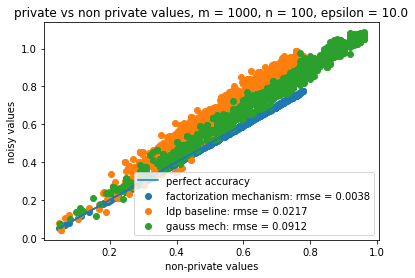

In [40]:
pyplot.scatter(output['non_private'], output['private'], label='factorization mechanism: rmse = {}'.format(fac_mse))
pyplot.plot(output['non_private'], output['non_private'], label='perfect accuracy')
pyplot.ylabel('noisy values')
pyplot.xlabel('non-private values')
pyplot.title('private vs non private values, m = {}, n = {}, epsilon = {}'.format(m, n, epsilon))
pyplot.scatter(output['non_private'], baseline_ldp['private'], label='ldp baseline: rmse = {}'.format(ldp_mse))
pyplot.scatter(naive_gauss['non_private'], naive_gauss['private'], label='gauss mech: rmse = {}'.format(gauss_mse))
pyplot.legend()
pyplot.show()
